In [4]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [5]:
# Creating a empty dict, where I will save all parameters required for test data transformation

saved_dict = {}

In [6]:
# Reading datasets
dfs = []
for i in range(1,5):
    path = r'C:\Users\tania\Desktop\UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [7]:
# This csv file contains names of all the features
df_col = pd.read_csv(r"C:\Users\tania\Desktop\Minor project\Coding\NUSW-NB15_features.csv", encoding='ISO-8859-1')

In [8]:
# Making column names lower case, removing spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [9]:
# Renaming our dataframe with proper column names
all_data.columns = df_col['Name']

In [10]:
# Saving useful info, later this will be used to transform raw test data
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

In [11]:
del df_col

In [12]:
all_data.shape

(2540047, 49)

In [13]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## Data cleaning and pre-processing

In [14]:
# Splitting data into train and test
# All the operation like cleaning, EDA and FE will be done on train data only

train, test = train_test_split(all_data, test_size=0.3, random_state=16)

In [15]:
# Deleting the concatenated dataframe, as we don't need that anymore
del all_data

In [16]:
print(train.shape,'\n',test.shape)

(1778032, 49) 
 (762015, 49)


In [17]:
# checking for null values
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [18]:
train['attack_cat'].value_counts()

Generic             150906
Exploits             31507
 Fuzzers             13345
DoS                  11433
 Reconnaissance       8544
 Fuzzers              3569
Analysis              1855
Backdoor              1242
Reconnaissance        1220
 Shellcode             904
Backdoors              374
Shellcode              151
Worms                  120
Name: attack_cat, dtype: int64

In [19]:
# We don't have "normal" values for "attack_cat", so we must fill Null values with "normal"
train['attack_cat'] = train.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [20]:
train['attack_cat'].value_counts()

normal            1552862
generic            150906
exploits            31507
fuzzers             16914
dos                 11433
reconnaissance       9764
analysis             1855
backdoor             1242
shellcode            1055
backdoors             374
worms                 120
Name: attack_cat, dtype: int64

In [21]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

In [22]:
# Even though it's a binary column, but there're values like 2 and 4
train['is_ftp_login'].value_counts()

0.0    746536
1.0     30329
4.0       109
2.0        21
Name: is_ftp_login, dtype: int64

In [23]:
train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)

In [24]:
# There are no Null values in the train data anymore
train.isnull().sum().sum()

0

## Information about dataset

In [25]:
# Getting name of all the columns
train.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object', name='Name')

## Class distribution

In [26]:
train_0, train_1 = train['label'].value_counts()[0] / len(train.index), train['label'].value_counts()[1] / len(train.index)
test_0, test_1 = test['label'].value_counts()[0] / len(test.index), test['label'].value_counts()[1] / len(test.index)

print("In Train: there are {} % of class 0 and {} % of class 1".format(train_0, train_1))
print("In Test: there are {} % of class 0 and {} % of class 1".format(test_0, test_1))

In Train: there are 0.8733599845222133 % of class 0 and 0.12664001547778667 % of class 1
In Test: there are 0.8738699369434985 % of class 0 and 0.1261300630565015 % of class 1


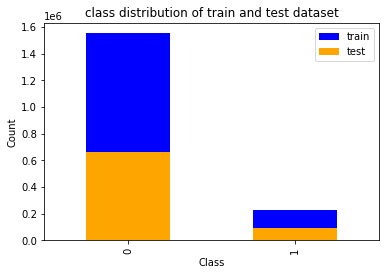

In [27]:
# Plotting target label distribution
plt.figure()
plt.title("class distribution of train and test dataset")
train['label'].value_counts().plot(kind="bar", color='b', label="train")
test['label'].value_counts().plot(kind="bar", color='orange', label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

Both train and test datasets are highly imbalanced.

Percentage of points belongs to class 1 (attack) is very little (only 12.6 %) in both of them.

In [28]:
# Check if any null value present in datasets
train.isnull().sum().sum(), test.isnull().sum().sum()  # No Null in train and test data is still raw

(0, 1499013)

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1778032 entries, 81030 to 2079982
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit      

In [30]:
# All the datatypes in our dataset
train.dtypes.value_counts()

int64      28
float64    11
object      9
int32       1
dtype: int64

In [31]:
# Categorical feature names
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')

In [32]:
# In the research paper it was mentioned that, this is a numerical feature not a categorical
train['ct_ftp_cmd'].unique()

array([0, ' ', 1, '1', '0', 5, 2, 3, 4, '4', 6, '2', 8], dtype=object)

In [33]:
# Removing empty space and converting it to numerical
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [34]:
train['ct_ftp_cmd'].unique()

array([0, 1, 5, 2, 3, 4, 6, 8])

In [35]:
# Categorical feature names
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'attack_cat'],
      dtype='object', name='Name')

In [36]:
# Numeric features names
train.select_dtypes(include=np.number).columns

Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')

In [37]:
# Info for test data transformation
saved_dict['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

## Fixing values of the columns

In [38]:
# see if binary columns are really binary
for col in 'is_sm_ips_ports', 'is_ftp_login':
    print(train[col].value_counts())
    print()

0    1775116
1       2916
Name: is_sm_ips_ports, dtype: int64

0    1747573
1      30329
4        109
2         21
Name: is_ftp_login, dtype: int64



The col "is_ftp_login" has few wrong values like 2, 4. It should only have 0 and 1, If the ftp session is accessed by user and password then 1 else 0. Need to fix this.

Replacing all the values apart from 0 and 1 from these two columns.

In [39]:
train['is_ftp_login'] = np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])

In [40]:
train['is_ftp_login'].value_counts()

0    1747573
1      30459
Name: is_ftp_login, dtype: int64

In the feature "service" we have "-" we need to replace that.

In [41]:
train['service'].value_counts()

-           872286
dns         547094
http        144555
ftp-data     88310
smtp         57160
ftp          34293
ssh          32897
pop3          1076
dhcp           124
ssl            109
snmp            81
radius          27
irc             20
Name: service, dtype: int64

In [42]:
# removing all the "-" and replacing those with "None"
train['service'] = train['service'].apply(lambda x:"None" if x=="-" else x)

In [43]:
train['service'].value_counts()

None        872286
dns         547094
http        144555
ftp-data     88310
smtp         57160
ftp          34293
ssh          32897
pop3          1076
dhcp           124
ssl            109
snmp            81
radius          27
irc             20
Name: service, dtype: int64

In [44]:
# In the research paper there are not 10 unique values
train['attack_cat'].nunique()

11

In [45]:
train['attack_cat'].value_counts()

normal            1552862
generic            150906
exploits            31507
fuzzers             16914
dos                 11433
reconnaissance       9764
analysis             1855
backdoor             1242
shellcode            1055
backdoors             374
worms                 120
Name: attack_cat, dtype: int64

In [46]:
train['attack_cat'] = train['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

## Saving files to disk

In [47]:
train.shape, test.shape

((1778032, 49), (762015, 49))

In [48]:
train.to_csv('./train_alldata_EDA.csv', index=False)
test.to_csv('./test_alldata_EDA.csv', index=False)

In [49]:
pickle.dump(saved_dict, open('./final_ipynb', 'wb'))